# 04 - Model Training & Evaluation

This notebook builds and trains a baseline machine learning model to predict mortgage prepayment risk. We use the engineered dataset from earlier steps and apply preprocessing steps like imputation and encoding before training a decision tree classifier.

## Objectives:
- Load preprocessed training and testing data
- Define a custom transformation pipeline:
  - Mean and constant imputation
  - One-hot encoding of categorical variables
  - State-based dummy variables
- Train a Decision Tree Classifier
- Evaluate model performance

## Summary

This notebook successfully builds a working machine learning pipeline for predicting mortgage prepayment. While the current model is a decision tree, future work can include hyperparameter tuning and more complex algorithms such as gradient boosting.

# Load data from previous session

In [1]:
import pandas as pd
import numpy as np
import pickle

In [2]:
# load from previous session
# X_train, X_test, y_train, y_test
# vars_impute_mean 
# vars_impute_constant
X_train=pd.read_pickle('X_train.pkl')
X_test=pd.read_pickle('X_test.pkl')
y_train=pd.read_pickle('y_train.pkl')
y_test=pd.read_pickle('y_test.pkl')
with open('vars_impute_mean.list','rb') as fp:
    vars_impute_mean=pickle.load(fp)
with open('vars_impute_constant.list','rb') as fp:
    vars_impute_constant=pickle.load(fp)

# add a few state dummies



In [3]:
X_train['Property State'].value_counts() / len(X_train)

CA    0.129517
TX    0.084754
FL    0.074420
WA    0.038615
CO    0.036717
IL    0.036408
AZ    0.034232
NY    0.031560
NC    0.031498
PA    0.029971
MI    0.029864
GA    0.029718
VA    0.028431
MN    0.025348
OH    0.024033
NJ    0.023257
OR    0.021561
MA    0.021331
MO    0.020698
WI    0.020038
TN    0.019933
UT    0.016969
SC    0.015841
MD    0.015581
NV    0.014233
IN    0.014168
LA    0.010476
AL    0.010422
IA    0.010374
KY    0.009025
CT    0.008298
ID    0.008164
OK    0.007761
NE    0.007200
AR    0.006762
KS    0.005434
NM    0.005293
MT    0.005062
NH    0.004677
MS    0.004089
HI    0.003959
RI    0.003369
SD    0.003312
DE    0.003021
ME    0.002657
ND    0.002308
WV    0.001839
WY    0.001808
DC    0.001727
PR    0.001644
VT    0.001302
AK    0.001234
VI    0.000089
Name: Property State, dtype: float64

# create pipeline

We define a function to cleanly apply all preprocessing steps: imputation, encoding, and feature selection.

In [4]:
# pipeline
def transformation_pipeline(df, vars_impute_mean, vars_impute_constant):
    df_imputed=df.copy()
    df_imputed[vars_impute_mean] = df[vars_impute_mean].fillna(df[vars_impute_mean].mean())
    for var in vars_impute_constant:
        print(df[var].dtype)
        if df[var].dtype == 'object': 
            df_imputed[var] = df[var].fillna("Missing")
        else:
            df_imputed[var] = df[var].fillna(0)
    df_imputed = pd.get_dummies(df_imputed, prefix=['Property Type'], columns = ['Property Type'], drop_first=True)
    df_imputed = pd.get_dummies(df_imputed, prefix=['Loan Purpose'], columns = ['Loan Purpose'], drop_first=True)
    df_imputed['state_ca'] = 1 *(df_imputed['Property State'] == 'CA')
    df_imputed['state_tx'] = 1 *(df_imputed['Property State'] == 'TX')
    df_imputed['state_fl'] = 1 *(df_imputed['Property State'] == 'FL')
    vars_to_drop = ['Loan Identifier','reporting_period', 'Property State']
    return df_imputed.drop(vars_to_drop, axis=1)


In [5]:
X_train_final = transformation_pipeline(X_train,vars_impute_mean, vars_impute_constant)

float64
float64
float64
float64
float64
float64
float64
float64
float64
object
object
object


In [6]:
#check if any missing value exists
X_train_final.isnull().values.any()

False

In [7]:
X_train_final.head()

,Original Interest Rate,Current Interest Rate,Original UPB,UPB at Issuance,Current Actual UPB,Original Loan Term,Origination Date,First Payment Date,Loan Age,Remaining Months to Legal Maturity,...,hpg_2y,Property Type_CP,Property Type_MH,Property Type_PU,Property Type_SF,Loan Purpose_P,Loan Purpose_R,state_ca,state_tx,state_fl
0,4.625,4.625,388000.0,384968.45,384968.45,360,42017,62017,6.0,354.0,...,0.115985,0,0,0,1,1,0,1,0,0
1,4.625,4.625,388000.0,384968.45,384456.32,360,42017,62017,7.0,353.0,...,0.118407,0,0,0,1,1,0,1,0,0
2,4.625,4.625,388000.0,384968.45,383942.22,360,42017,62017,8.0,352.0,...,0.120437,0,0,0,1,1,0,1,0,0
3,4.625,4.625,388000.0,384968.45,383426.14,360,42017,62017,9.0,351.0,...,0.123372,0,0,0,1,1,0,1,0,0
4,4.625,4.625,388000.0,384968.45,382909.07,360,42017,62017,10.0,350.0,...,0.124420,0,0,0,1,1,0,1,0,0


# model fitting

In [8]:
from sklearn import tree

In [10]:
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=30, random_state=0)

In [11]:
clf.fit(X_train_final.select_dtypes(exclude='object'), y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=30, random_state=0)

### view the tree

In [12]:
feature_names = list( X_train_final.select_dtypes(exclude='object').columns)

In [13]:
with open('tree.txt', 'w+') as f:
    f.write(tree.export_text(clf,feature_names=feature_names))

In [14]:
clf.get_depth()

30

In [15]:
clf.get_n_leaves()

13485

In [16]:
X_train_final.shape

(789358, 61)

# model performance: in-sample

## 1. accuracy

In [17]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [18]:
y_pred = clf.predict(X_train_final.select_dtypes(exclude='object'))

In [19]:
accuracy_score(y_train, y_pred)

0.9959448057788735

In [20]:
np.unique(y_pred, return_counts=True)  

(array([False,  True]), array([781168,   8190]))

In [21]:
np.unique(y_train, return_counts=True)  

(array([False,  True]), array([778101,  11257]))

In [22]:
778101 / (778101+11257)

0.9857390436278596

## 2. confusion matrix

In [23]:
confusion_matrix(y_train, y_pred)

array([[778034,     67],
       [  3134,   8123]])

# model performance: out-of-sample

In [24]:
X_test_final = transformation_pipeline(X_test,vars_impute_mean, vars_impute_constant)

float64
float64
float64
float64
float64
float64
float64
float64
float64
object
object
object


In [25]:
y_test_pred = clf.predict(X_test_final.select_dtypes(exclude='object'))

In [26]:
accuracy_score(y_test, y_test_pred)

0.9670494778495136

In [29]:
np.unique(y_test_pred, return_counts=True)  

(array([False,  True]), array([329502,   6608]))

In [30]:
np.unique(y_test, return_counts=True)  

(array([False,  True]), array([331233,   4877]))

In [31]:
331233 / (331233+4877)

0.985489869387998

In [27]:
confusion_matrix(y_test, y_test_pred)

array([[324830,   6403],
       [  4672,    205]])

# pruning

In [32]:
import sklearn.model_selection as skm

In [33]:
import matplotlib.pyplot as plt

In [34]:
ccp_path = clf.cost_complexity_pruning_path(X_train_final.select_dtypes(exclude='object'), y_train) 
kfold = skm.KFold(10, random_state=1, shuffle=True)

In [35]:
ccp_alphas, impurities = ccp_path.ccp_alphas, ccp_path.impurities

In [36]:
ccp_alphas

array([0.00000000e+00, 1.57737364e-06, 1.57737364e-06, ...,
       4.65910272e-04, 1.03375767e-03, 5.02241490e-03])

In [37]:
len(ccp_alphas)

6233

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

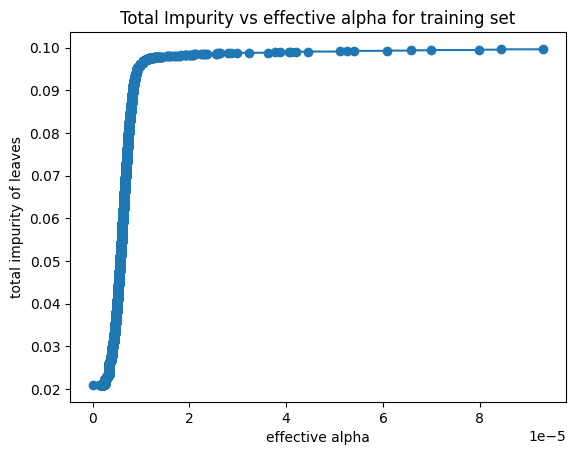

In [38]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-10], impurities[:-10], marker="o", drawstyle="steps-post")
#ax.plot(ccp_alphas, impurities, marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [39]:
ccp_alphas_small = [x / 2e6 for x in range(20)]

In [40]:
ccp_alphas_small

[0.0,
 5e-07,
 1e-06,
 1.5e-06,
 2e-06,
 2.5e-06,
 3e-06,
 3.5e-06,
 4e-06,
 4.5e-06,
 5e-06,
 5.5e-06,
 6e-06,
 6.5e-06,
 7e-06,
 7.5e-06,
 8e-06,
 8.5e-06,
 9e-06,
 9.5e-06]

In [185]:
clfs = []
for ccp_alpha in ccp_alphas_small:
    clf = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train_final.select_dtypes(exclude='object'), y_train)
    clfs.append(clf)

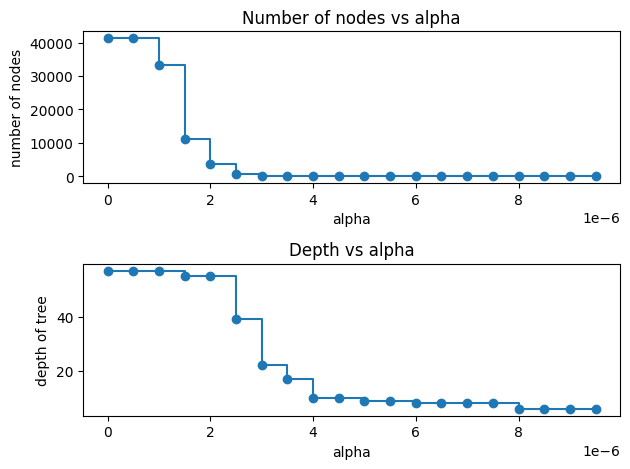

In [187]:
node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas_small, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas_small, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

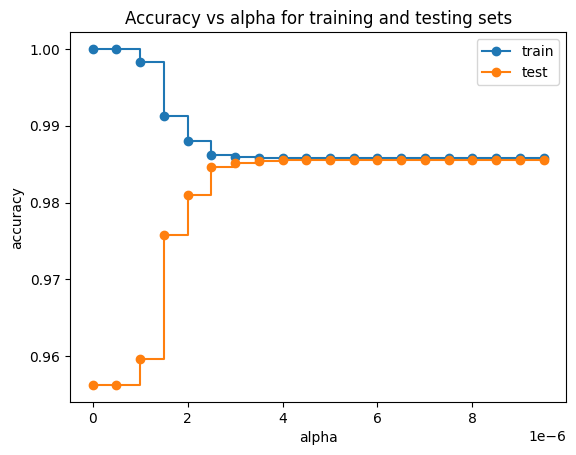

In [188]:
train_scores = [clf.score(X_train_final.select_dtypes(exclude='object'), y_train) for clf in clfs]
test_scores = [clf.score(X_test_final.select_dtypes(exclude='object'), y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas_small, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas_small, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

# a customized, alternative metric

In [179]:
def customized_metric(X, y, model):
    y_pred = model.predict(X)
    y_pred_mean=y_pred.mean()
    y_mean = y.mean()
    score = abs(y_mean - y_pred_mean)
    return score
    

In [189]:
train_scores_alt = [customized_metric(X_train_final.select_dtypes(exclude='object'), y_train, clf) for clf in clfs]
test_scores_alt = [customized_metric(X_test_final.select_dtypes(exclude='object'), y_test, clf) for clf in clfs]


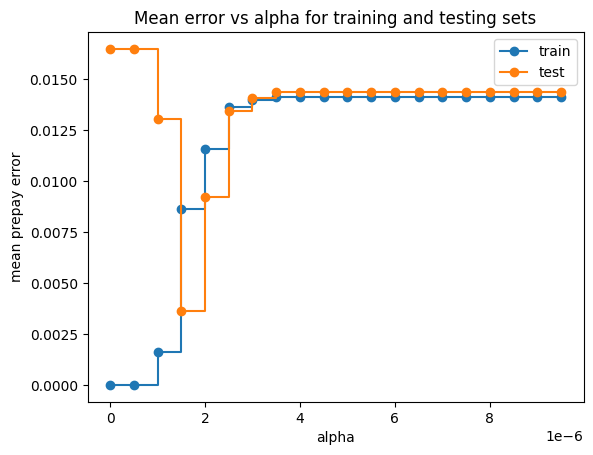

In [190]:
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("mean prepay error")
ax.set_title("Mean error vs alpha for training and testing sets")
ax.plot(ccp_alphas_small, train_scores_alt, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas_small, test_scores_alt, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

# re-fit the model using pruned alpha

In [197]:
alpha_chosen = 1.5e-6

In [203]:
clf_final = tree.DecisionTreeClassifier(criterion='gini', ccp_alpha=alpha_chosen, random_state=0)

In [204]:
clf_final.fit(X_train_final.select_dtypes(exclude='object'), y_train)

DecisionTreeClassifier(ccp_alpha=1.5e-06, random_state=0)

In [200]:
y_test_pred = clf_final.predict(X_test_final.select_dtypes(exclude='object'))

In [201]:
confusion_matrix(y_test, y_test_pred)

array([[322642,   8591],
       [  4602,    275]])

In [205]:
customized_metric(X_test_final.select_dtypes(exclude='object'), y_test, clf_final)

0.003605962333759781

In [208]:
#view the tree
with open('tree_final.txt', 'w+') as f:
    f.write(tree.export_text(clf_final,feature_names=feature_names, show_weights=True))

In [210]:
clf_final.get_n_leaves()

5590

In [211]:
clf_final.get_depth()

55